Source: https://towardsdatascience.com/efficient-frontier-portfolio-optimisation-in-python-e7844051e7f

In [214]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import quandl
import scipy.optimize as sco
plt.style.use('fivethirtyeight')
np.random.seed(777)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [285]:
quandl.ApiConfig.api_key = 'UvsDBZngPJquEbsSTBYS'
data = []
assets = ["BTCUSD", "ETHUSD", "LTCUSD", "XRPUSD", "ZECUSD"]
for asset in assets:
    print("Downloading "+asset+"...")
    new_data = quandl.get('BITFINEX/'+asset, start_date='2016-01-01', end_date='2019-06-04')["Last"]
    new_data.name = asset
    data.append(new_data)
num_assets = len(assets) 
table = pd.concat([idata for idata in data], axis=1)

In [286]:
table.head()

,BTCUSD,ETHUSD,LTCUSD,XRPUSD,ZECUSD
Date,,,,,
2016-01-01,433.78,NaN,3.5100,NaN,NaN
2016-01-02,433.20,NaN,3.4917,NaN,NaN
2016-01-03,427.98,NaN,3.4801,NaN,NaN
2016-01-04,434.49,NaN,3.5073,NaN,NaN
2016-01-05,431.82,NaN,3.4918,NaN,NaN


In [287]:
table = table.dropna()
table.head()

,BTCUSD,ETHUSD,LTCUSD,XRPUSD,ZECUSD
Date,,,,,
2017-05-19,1970.0,125.79,26.824,0.31800,105.84
2017-05-20,2068.0,126.30,27.467,0.34689,106.75
2017-05-21,2037.9,144.40,26.050,0.33345,117.71
2017-05-22,1981.9,137.00,23.291,0.28001,194.10
2017-05-23,2228.0,167.02,29.750,0.32090,250.00


Text(0, 0.5, 'price in $')

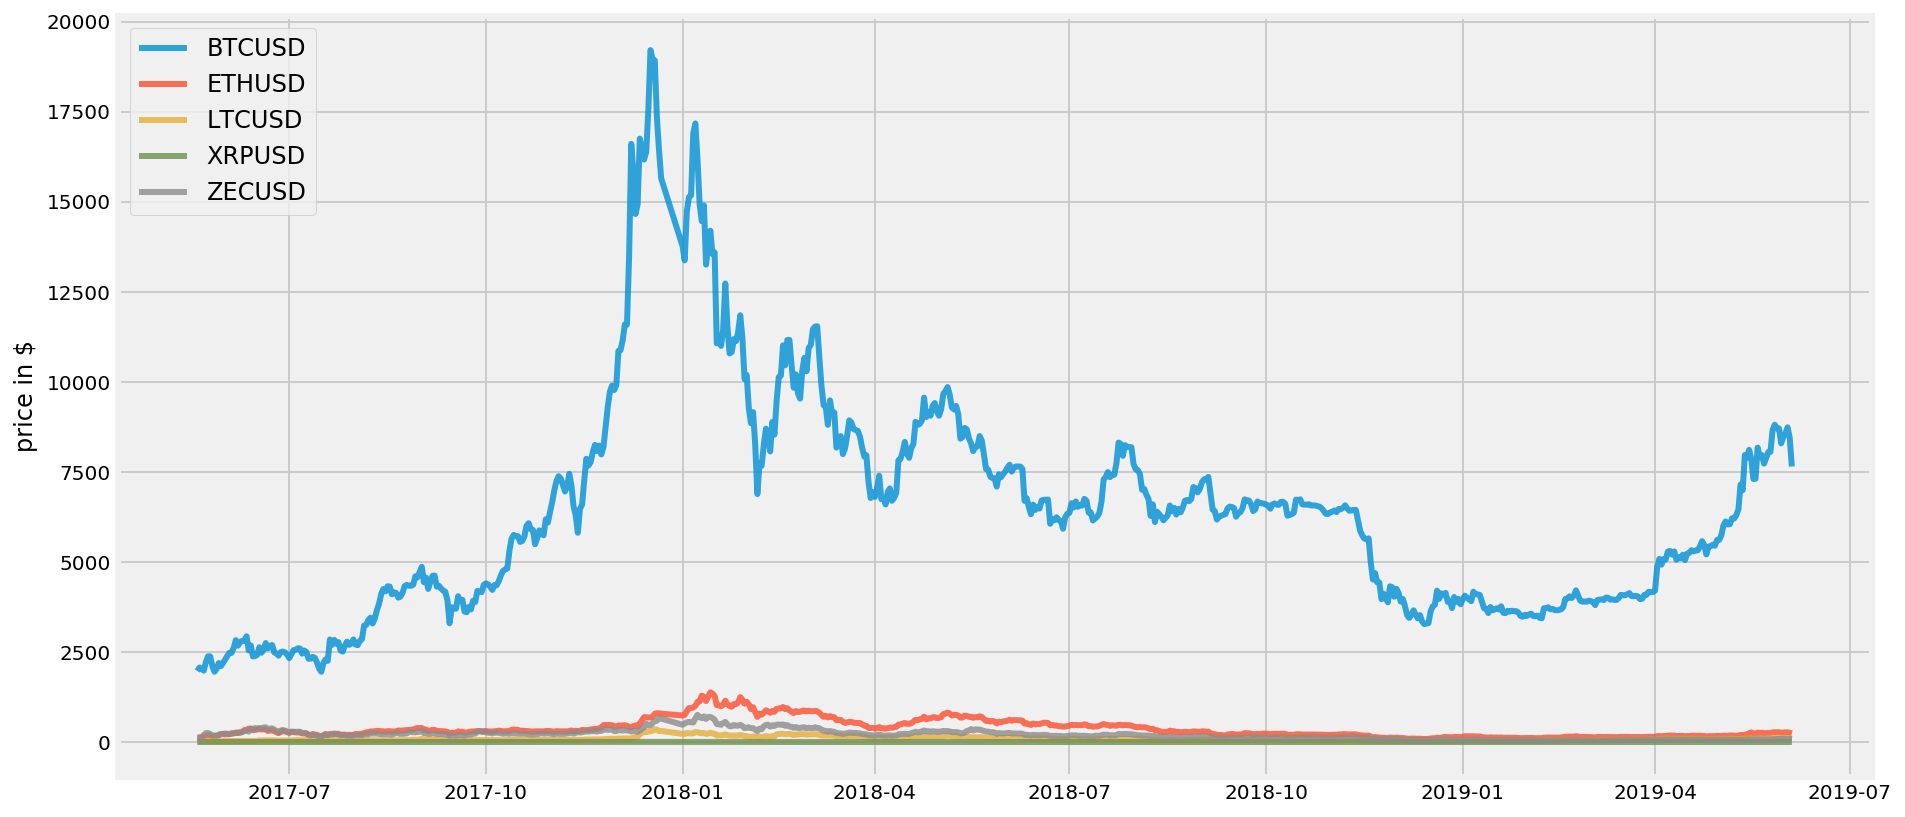

In [288]:
plt.figure(figsize=(14, 7))
for c in table.columns.values:
    plt.plot(table.index, table[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in $')

Text(0, 0.5, 'daily returns')

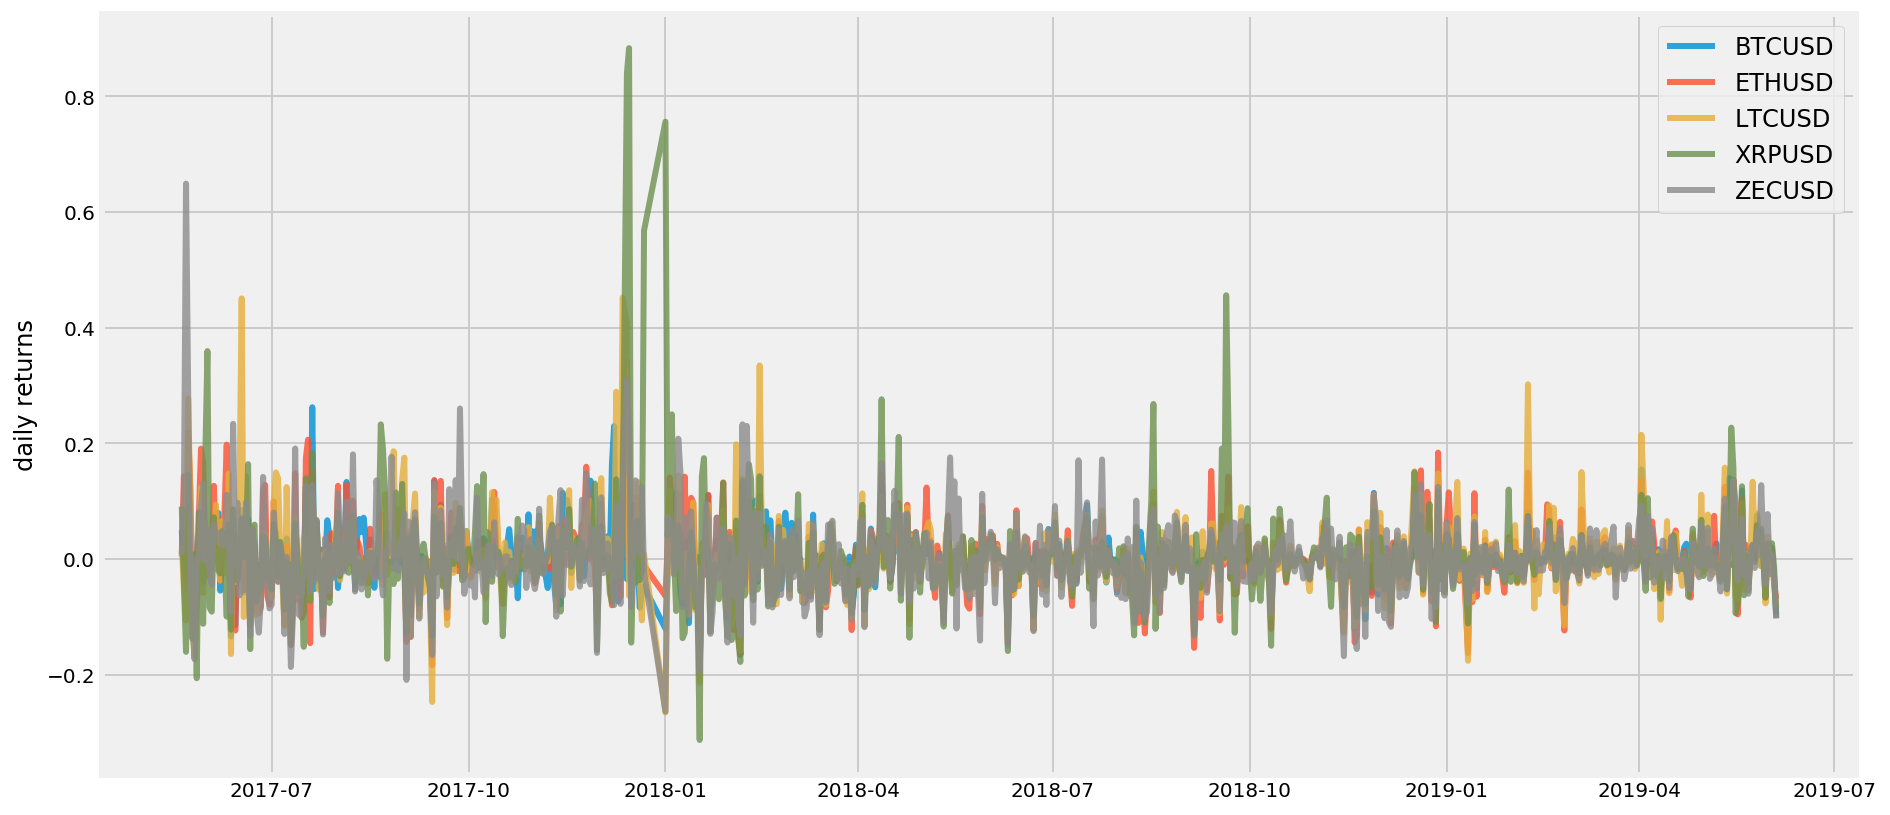

In [289]:
returns = table.pct_change()
plt.figure(figsize=(14, 7))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('daily returns')

In [302]:
trading_days_per_year = 365

def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *trading_days_per_year
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(trading_days_per_year)
    return std, returns
  
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

In [344]:
returns = table.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 50000
risk_free_rate = 0.0178

# Minimization on Randomized Portfolios

In [345]:
def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualized Return:", round(rp,2))
    print ("Annualized Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualized Return:", round(rp_min,2))
    print ("Annualized Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    
    
    print ("-"*80)
    an_vol = np.std(returns) * np.sqrt(trading_days_per_year)
    an_rt = mean_returns * trading_days_per_year
    print ("Individual Stock Returns and Volatility\n")
    for i, txt in enumerate(table.columns):
        print (txt,":","Annualized return",round(an_rt[i],2),", Annualiszd volatility:",round(an_vol[i],2))
    print ("-"*80) 
       
    
    plt.figure(figsize=(13, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('Annualized Votility')
    plt.ylabel('Annualized Returns')
    plt.legend(labelspacing=0.8)
    
    
    #fig, ax = plt.subplots(figsize=(10, 7))
    plt.scatter(an_vol,an_rt,marker='o',s=200)
    for i, txt in enumerate(table.columns):
        plt.annotate(txt, (an_vol[i],an_rt[i]), xytext=(10,0), textcoords='offset points')
    

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualized Return: 1.21
Annualized Volatility: 0.93


            BTCUSD  ETHUSD  LTCUSD  XRPUSD  ZECUSD
allocation   60.25    1.55   25.04   12.71    0.46
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualized Return: 1.06
Annualized Volatility: 0.88


            BTCUSD  ETHUSD  LTCUSD  XRPUSD  ZECUSD
allocation   75.05    12.9    1.63    4.49    5.93
--------------------------------------------------------------------------------
Individual Stock Returns and Volatility

BTCUSD : Annualized return 1.08 , Annualiszd volatility: 0.89
ETHUSD : Annualized return 0.99 , Annualiszd volatility: 1.16
LTCUSD : Annualized return 1.49 , Annualiszd volatility: 1.32
XRPUSD : Annualized return 1.29 , Annualiszd volatility: 1.68
ZECUSD : Annualized return 0.71 , Annualiszd volatility: 1.35
----------

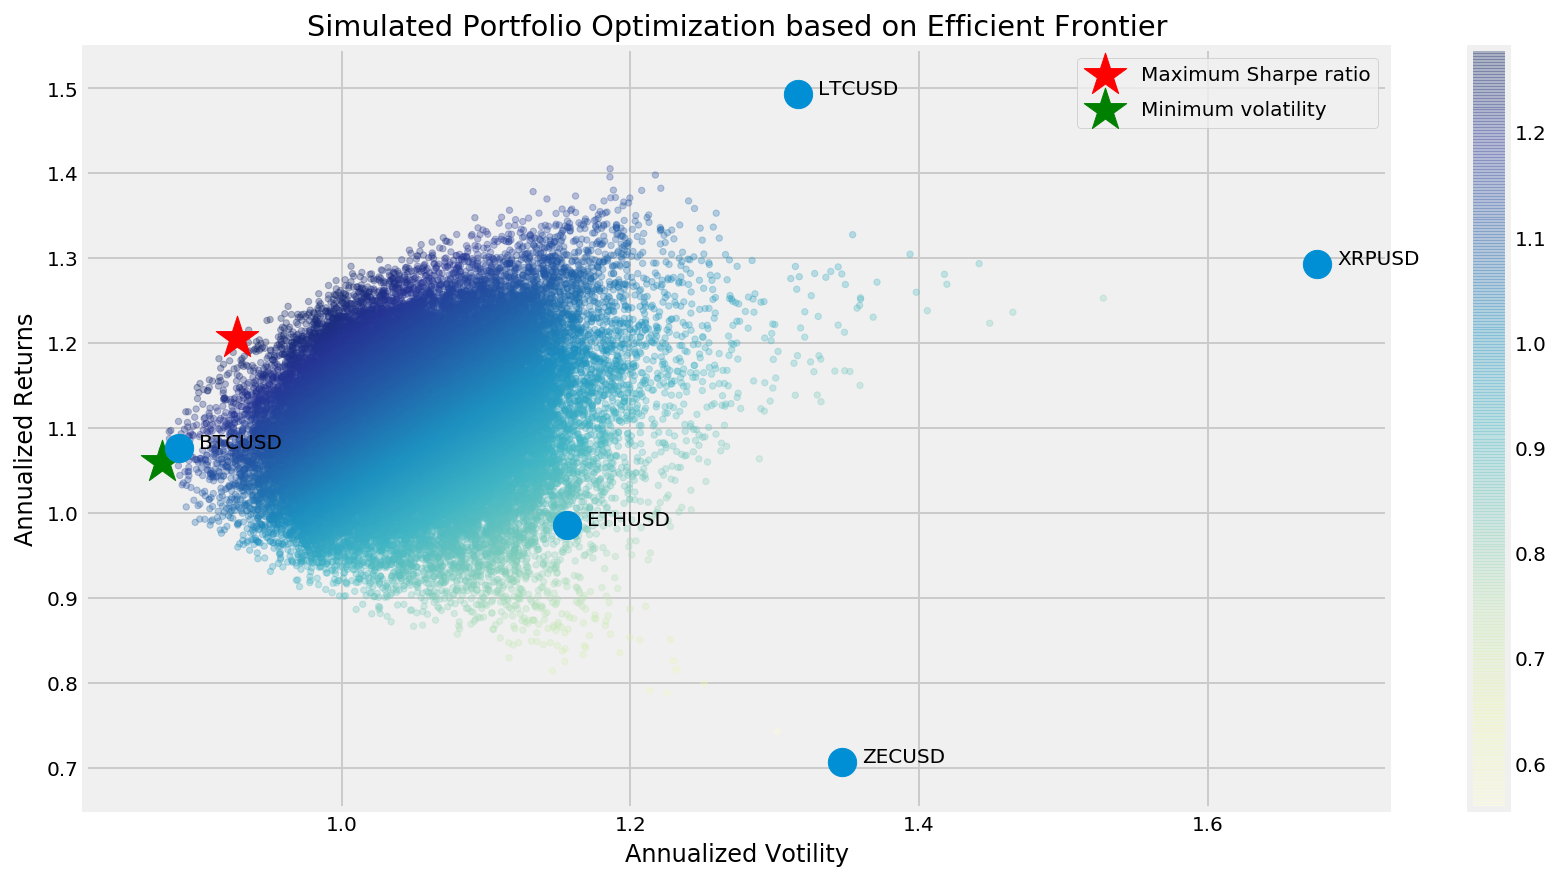

In [346]:
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)